## Demo: Isotropic Reconstruction of Downsampled Openoraganelle Mouse Liver Dataset.
This notebook demonstrates applying a vEMDiffuse-i model for an isotropic reconstruction task. In this example, we will use the [vEMDiffuse-i model weight](https://connecthkuhk-my.sharepoint.com/personal/u3590540_connect_hku_hk/_layouts/15/onedrive.aspx?ga=1&id=%2Fpersonal%2Fu3590540%5Fconnect%5Fhku%5Fhk%2FDocuments%2FEMDiffuse%5Fmodel%5Fweight%2FvEMDiffuse%2Di) trained on the Openoraganelle Mouse Liver Dataset to reconstruct an isotropic volume with a pixel size of 8 nm x 8 nm x 8 nm from downsampled volume with a pixel size of 8 nm x 8 nm x 48 nm. 

The trained model is assumed to be in the folder ``experiments`` with the name `vEMDiffuse-i`. 


The demo image is stored in `demo/mouse_liver_demo`. `0.tif` and `1.tif` are two regions cropped from the Openoraganelle Mouse Liver Dataset, whose axial distance is 48 nm. We will generate five layers between them to achieve isotropic resolution.

The diffusion process on the CPU is relatively slow. So, it is recommended that prediction be run on GPU. 


## Download and Install EMDiffuse

In [ ]:
!git clone https://github.com/Luchixiang/EMDiffuse
%cd EMDiffuse/
!pip install -r requirements.txt

Note: Before starting, ensure that you're working within the 'EMDiffuse' directory. The directory can be checked with the `!pwd` command and adjusted with the `%cd` command. 

In [1]:
# %cd ../..

/home/cxlu/EMDiffuse


In [2]:
import core.praser as Praser
import os
import warnings
import torch
import torch.multiprocessing as mp
from tifffile import imread
from crop_single_file import crop
from core.logger import VisualWriter, InfoLogger
import core.praser as Praser
import core.util as Util
from data import define_dataloader
from models import create_EMDiffuse
from emdiffuse_conifg import EMDiffuseConfig
import matplotlib.pyplot as plt

## Show Demo Data

Text(0.5, 1.0, 'Layer2 2')

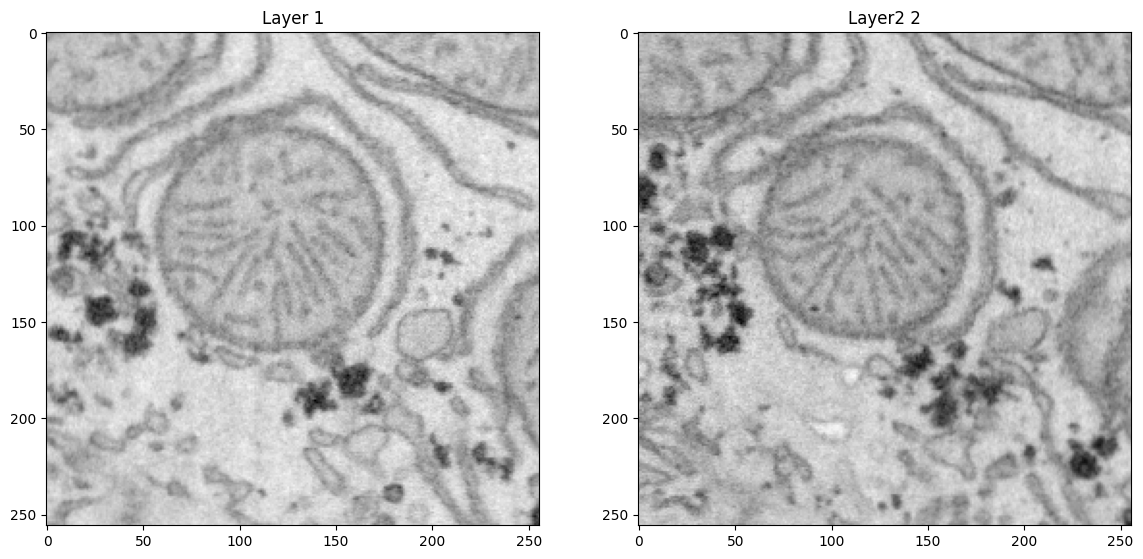

In [3]:
test_path = './demo/mouse_liver_demo'
example_image_layer1 = imread(os.path.join(test_path, '0.tif'))
example_image_layer2 = imread(os.path.join(test_path, '1.tif'))
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(example_image_layer1, cmap='gray')
plt.title('Layer 1')
plt.subplot(1,2,2)
plt.imshow(example_image_layer2, cmap='gray')
plt.title('Layer2 2')

## Download the Pretrained Model Weight

In [8]:
import urllib
import zipfile
if not os.path.isdir('./experiments'):
    os.mkdir('./experiments')
# Download the model weight trained on the Openorganelle Mouse Liver Dataset. Skip this step if you prefer to use your own trained model.
zipPath="experiments/vEMDiffuse-i.zip"
if not os.path.exists(zipPath):
    #download and unzip data
    data = urllib.request.urlretrieve('https://zenodo.org/records/10686030/files/vEMDiffuse-i.zip?download=1', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("experiments")

## vEMDiffuse-i Model

Load the trained model (located in `experiments` with the name `vEMDiffuse-i`) from disk.
When loading the model for testing, we replicate the training configuration with the addition of a few testing-specific parameters:
- batch size: test batch size.
  
- mean: Diffusion model samples one plausible solution from the learned solution distribution. Mean denotes the number of outputs you want to generate and average.
  
- resume: The path to the model's weights file and the epoch number from which to load the model.
  
- step: The number of diffusion steps. More steps, higher image quality.
- subsample: The subsampling factor of the Z axis. In this example, to reconstruct an 8 nm x 8 nm x 8 nm volume from an 8 nm x 8 nm x 48 nm volume, the subsampling factor should be 6.


In [5]:
config = EMDiffuseConfig(config='config/vEMDiffuse-i.json', phase='test', 
                         path='./demo/mouse_liver_demo', batch_size=1, mean=1, subsample=6, resume='./experiments/vEMDiffuse-i/best', step=200)
opt = Praser.parse(config) # Parse the config
opt['world_size'] = 1 
Util.set_seed(opt['seed'])
model = create_EMDiffuse(opt)
print(f'len test data loader: {len(model.phase_loader)}')

results and model will be saved in experiments/test_vEMDiffuse-i_240221_142506
len test data loader: 1


## Testing
The generated layers and logger information are automatically saved within a newly created directory, as logged above. If you find the results are total noise images, it is mostly likely because you didn't load the model weight properly.

In [6]:
model.test()

sampling loop time step: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:17<00:00, 11.40it/s]


## Show Generated Layers

Text(0.5, 1.0, '7th Layer')

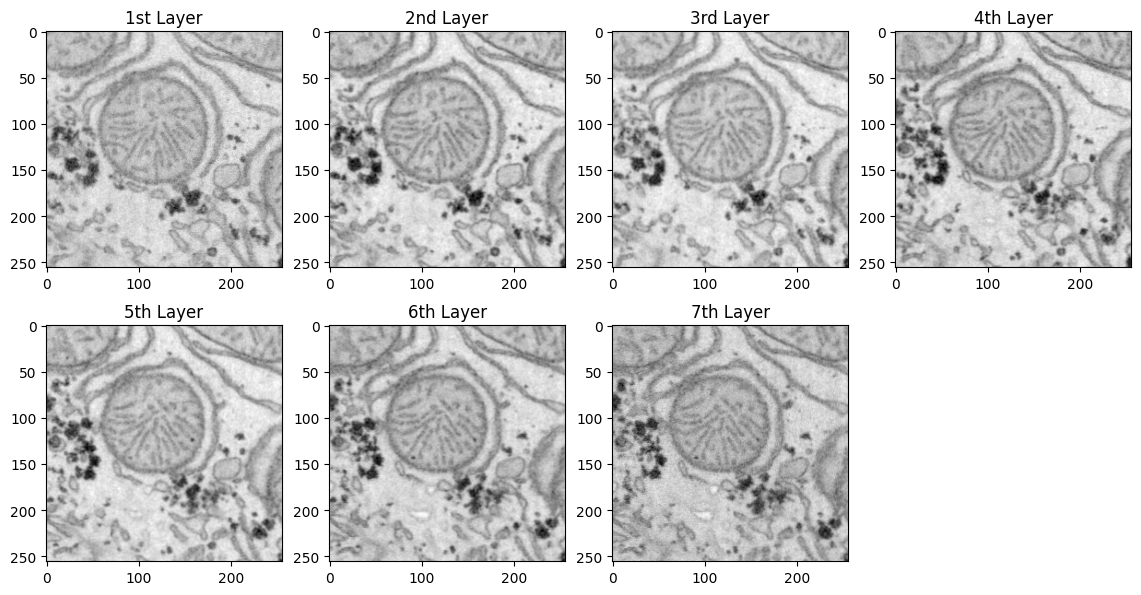

In [7]:
import glob
results_path = os.path.join(opt['path']['experiments_root'], 'results', 'test', '0') # you should replace the results path with the folder name logged above
layer_0 = glob.glob(os.path.join(results_path, 'Input_lower_*.tif'))[0]
layer_1 = layer_0.replace('Input_lower', 'Out_0')
layer_2 = layer_0.replace('Input_lower', 'Out_1')
layer_3 = layer_0.replace('Input_lower', 'Out_2')
layer_4 = layer_0.replace('Input_lower', 'Out_3')
layer_5 = layer_0.replace('Input_lower', 'Out_4')
layer_6 = layer_0.replace('Input_lower', 'Input_upper')
plt.figure(figsize=(14,7))
plt.subplot(2,4,1)
plt.imshow(imread(layer_0), cmap='gray')
plt.title('1st Layer')
plt.subplot(2,4,2)
plt.imshow(imread(layer_1), cmap='gray')
plt.title('2nd Layer')
plt.subplot(2,4,3)
plt.imshow(imread(layer_2), cmap='gray')
plt.title('3rd Layer')
plt.subplot(2,4,4)
plt.imshow(imread(layer_3), cmap='gray')
plt.title('4th Layer')
plt.subplot(2,4,5)
plt.imshow(imread(layer_4), cmap='gray')
plt.title('5th Layer')
plt.subplot(2,4,6)
plt.imshow(imread(layer_5), cmap='gray')
plt.title('6th Layer')
plt.subplot(2,4,7)
plt.imshow(imread(layer_6), cmap='gray')
plt.title('7th Layer')